# Fixtures Status

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesMarketDataAPI/RateTrend.ipynb) 

This example plots the number of fixtures per month, grouped by status for Very Large Crude Carriers (VLCCs)

<h3>Setup</h3>

Install the Signal Ocean SDK:

In [ ]:
pip install signal-ocean

Import required libraries / APIs / packages:

<h3>Import Voyages Market Data API and some additional libraries</h3>

In [1]:
import pandas as pd
import plotly.express as px
from datetime import date, timedelta, datetime

from signal_ocean import Connection
from signal_ocean.voyages_market_data import VoyagesMarketDataAPI

Fill in your personal SignalOcean API subscription key acquired <a href="https://apis.signalocean.com/profile" target="_blank">here</a> and open a connection:

In [2]:
signal_ocean_api_key = '' #replace with your subscription key

Create a connection

In [3]:
connection = Connection(signal_ocean_api_key)
api = VoyagesMarketDataAPI(connection)

<h3>Call the API to Get market data</h3>

In [2]:
result = api.get_voyage_market_data(vessel_class_id=84, include_fixtures = True, include_matched_fixture = True, include_labels = True)

Get data into a dataframe

In [3]:
voyages_market_data = pd.DataFrame([r.__dict__ for r in result])

Extract date info from matched fixture

In [4]:
voyages_market_data = voyages_market_data[voyages_market_data['matched_fixture'].notna()]
voyages_market_data['Date'] = voyages_market_data['matched_fixture'].apply(lambda mf: mf.laycan_from)

<h3>Transform Data</h3>

Drop rows that have no date

In [5]:
voyages_market_data = voyages_market_data[voyages_market_data.Date.map(lambda d: isinstance(d,datetime))]

Expand the dataframe to have one row per fixture and extract fixture_status

In [6]:
voyages_market_data=voyages_market_data.explode('fixtures').reset_index(drop=True)
voyages_market_data['fixture_status'] = voyages_market_data['fixtures'].apply(lambda f: f.fixture_status)

Keep only rows with fixture_status info

In [7]:
voyages_market_data = voyages_market_data[voyages_market_data['fixture_status'].notna()][['Date', 'fixture_status', 'voyage_id']]

Keep one fixture report for each status per voyage

In [8]:
voyages_market_data = voyages_market_data.drop_duplicates(subset=['voyage_id', 'fixture_status'], keep='last')
voyages_market_data.head()

,Date,fixture_status,voyage_id
62,2011-07-09 00:00:00+00:00,FullyFixed,I8818E7VEC5455F00
67,2011-08-28 00:00:00+00:00,FullyFixed,I8818E7VEC5BC0600
74,2011-10-10 00:00:00+00:00,FullyFixed,I8818E7VEC60B2000
77,2012-01-25 00:00:00+00:00,OnSubs,I8818E7VEC681C700
81,2012-03-05 00:00:00+00:00,FullyFixed,I8818E7VEC6D0E100


Keep only Month and year info on Date

In [9]:
voyages_market_data['Date'] = pd.to_datetime(voyages_market_data['Date'], utc=True).dt.to_period('M')
voyages_market_data.head()

C:\Users\l.kolonis\Anaconda3\envs\python38\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,Date,fixture_status,voyage_id
62,2011-07,FullyFixed,I8818E7VEC5455F00
67,2011-08,FullyFixed,I8818E7VEC5BC0600
74,2011-10,FullyFixed,I8818E7VEC60B2000
77,2012-01,OnSubs,I8818E7VEC681C700
81,2012-03,FullyFixed,I8818E7VEC6D0E100


<h3>Group and plot</h3>

In [10]:
voyages_market_data_grouped = voyages_market_data.groupby(['Date', 'fixture_status']).size().reset_index(name="Count")
voyages_market_data_grouped.sort_values(['Date'], ascending = True, inplace = True)
voyages_market_data_grouped.tail()

,Date,fixture_status,Count
463,2022-07,Failed,5
467,2022-08,FullyFixed,51
468,2022-08,OnSubs,113
466,2022-08,Failed,9
469,2022-09,OnSubs,3


In [11]:
voyages_market_data_grouped=voyages_market_data_grouped[voyages_market_data_grouped['Date']>='2020-01']
voyages_market_data_grouped['Date'] = voyages_market_data_grouped['Date'].astype(str)

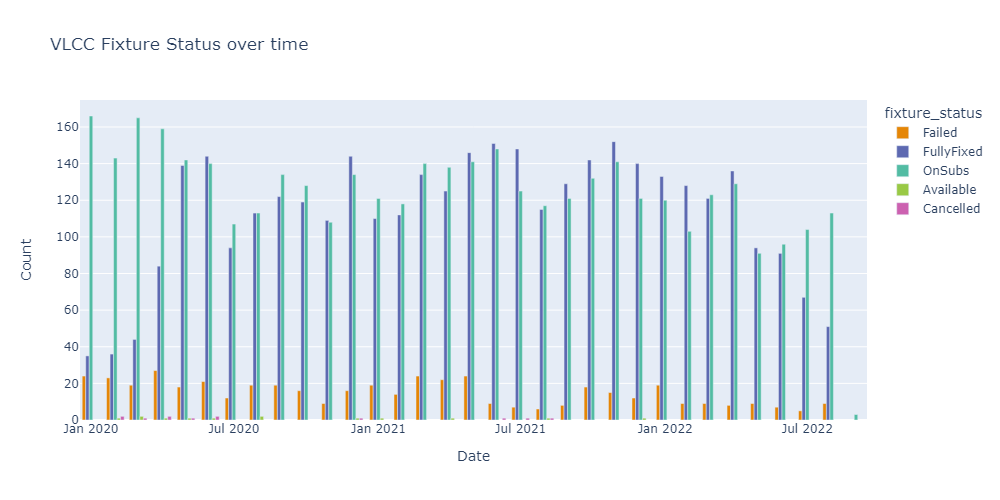

In [14]:
fig = px.bar(voyages_market_data_grouped, x="Date", y="Count", color='fixture_status', orientation='v',
             barmode='group', height=500, width=1000,
             title='VLCC Fixture Status over time',
             color_discrete_sequence=px.colors.qualitative.Vivid)
fig.show()